In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
from data_util import load_data

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.1.2
numpy 1.19.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
(x_train_all, y_train_all), (x_test, y_test) = load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [11]:
# tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
# 直接通过循环的方式添加全连接层
for _ in range(20):
    
#     第一种方式，BatchNormalization加载激活函数之前
    """
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    """
    
#     第二种方式，BatchNormalization加载激活函数之后
    
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    
    
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer='sgd', metrics=["accuracy"])

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               78500     
_________________________________________________________________
batch_normalization_20 (Batc (None, 100)               400       
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_21 (Batc (None, 100)               400       
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_22 (Batc (None, 100)              

In [13]:
# Tensorboard, earlystopping, modelcheckpoint
logdir = './dnn-bn-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]

history = model.fit(x_train_scaled, y_train, epochs=10,
                   validation_data=(x_valid_scaled, y_valid),
                   callbacks=callbacks)

Epoch 1/10
1719/1719 [==============================] - 32s 18ms/step - loss: 1.1128 - accuracy: 0.6060 - val_loss: 0.6608 - val_accuracy: 0.7616
Epoch 2/10
1719/1719 [==============================] - 31s 18ms/step - loss: 0.7608 - accuracy: 0.7321 - val_loss: 0.5377 - val_accuracy: 0.8044
Epoch 3/10
1719/1719 [==============================] - 31s 18ms/step - loss: 0.6593 - accuracy: 0.7710 - val_loss: 0.4788 - val_accuracy: 0.8294
Epoch 4/10
1719/1719 [==============================] - 32s 18ms/step - loss: 0.5915 - accuracy: 0.7945 - val_loss: 0.4952 - val_accuracy: 0.8218
Epoch 5/10
1719/1719 [==============================] - 32s 19ms/step - loss: 0.5456 - accuracy: 0.8113 - val_loss: 0.4357 - val_accuracy: 0.8514
Epoch 6/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.5122 - accuracy: 0.8195 - val_loss: 0.4412 - val_accuracy: 0.8414
Epoch 7/10
1719/1719 [==============================] - 32s 18ms/step - loss: 0.4893 - accuracy: 0.8282 - val_loss: 0.3874 -

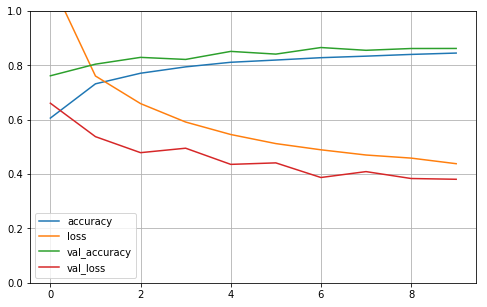

In [14]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
# 批归一化缓解梯度消失

In [15]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.4220 - accuracy: 0.8508


[0.4219745993614197, 0.8507999777793884]